# Voxel Reconstruction

In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio.v3 as iio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering

## Camera / Dataset

In [2]:
batch_size = 1024

train_origins, train_directions, train_target_pixel_values = get_rays('fox', mode='train')
data_loader = DataLoader(torch.cat((
        torch.from_numpy(train_origins), 
        torch.from_numpy(train_directions), 
        torch.from_numpy(train_target_pixel_values)), dim=1),
    batch_size=batch_size, shuffle=True)

test_origins, test_directions, test_target_pixel_values = get_rays('fox', mode='test')

## Rendering

## Model

In [23]:
class Voxels(nn.Module):

    def __init__(self, number_voxels=100, scale=1, device='cpu'):
        super(Voxels, self).__init__()

        self.voxels = torch.nn.Parameter(torch.rand((number_voxels, number_voxels, number_voxels, 4), device = device, requires_grad=True))

        self.number_voxels = number_voxels
        self.device = device
        self.scale = scale

    def forward(self, xyz):
        
        x = xyz[:, 0]
        y = xyz[:, 1]
        z = xyz[:, 2]

        cond = (x.abs() < (self.scale / 2)) & (y.abs() < (self.scale / 2)) & (z.abs() < (self.scale / 2))

        index_x = (x[cond] / ((self.scale / self.number_voxels)) + self.number_voxels / 2).type(torch.long)
        index_y = (y[cond] / ((self.scale / self.number_voxels)) + self.number_voxels / 2).type(torch.long)
        index_z = (z[cond] / ((self.scale / self.number_voxels)) + self.number_voxels / 2).type(torch.long)

        colors_and_density = torch.zeros((xyz.shape[0], 4))
        colors_and_density[cond, :3] = self.voxels[index_x, index_y, index_z, :3]
        colors_and_density[cond, -1] = self.voxels[index_x, index_y, index_z, -1]

        return torch.sigmoid(colors_and_density[:, :3]), torch.relu(colors_and_density[:, -1:])

    def intersect(self, x):
        return self.forward(x)

In [24]:
model = Voxels(scale=1.)

In [25]:
image = rendering(model, torch.from_numpy(train_origins[0]), torch.from_numpy(train_directions[0]), 8, 12)

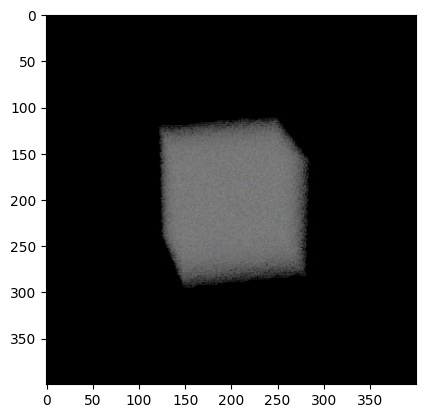

In [26]:
plt.imshow(image.reshape(400, 400, 3).data.cpu().numpy())

## Training